<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загружаем-данные-и-готовим-их-к-анализу" data-toc-modified-id="Загружаем-данные-и-готовим-их-к-анализу-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загружаем данные и готовим их к анализу</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Изучим-воронку-событий" data-toc-modified-id="Изучим-воронку-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучим воронку событий</a></span></li><li><span><a href="#Изучим-результаты-эксперимента" data-toc-modified-id="Изучим-результаты-эксперимента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучим результаты эксперимента</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Анализ поведения пользователей в мобильном приложении

В данном исследование проводится анализ гипотез по изменению шрифта в мобильном приложении. Необходимо изучить:
- воронку событий;
- сколько пользователей доходит до покупки;
- сколько пользователей застревают на других шагах;
- исследовать результаты A/A/B-эксперимента, по измению шрифта в приложении.

В нашем распоряжении логи пользователей. Каждая запись в логе — это действие пользователя, или событие. 


## Загружаем данные и готовим их к анализу

In [1]:
#импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep ='\t')
#читаем файл

In [3]:
#получение общей информации о датафрейме
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
#заменяем названия столбцов
data = data.rename(columns ={'EventName':'event', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time', 'ExpId':'group'})

In [5]:
data.duplicated().sum()
#проверка на наличие дубликатов

413

Дубликатов 413 строк, а всего строк 244125, процент дубликатов менее 1%, их можно удалить:

In [6]:
data = data.drop_duplicates()
#удаляем дубликаты
print(data.duplicated().sum()) 

0


In [7]:
data.isna().sum()
#проверка на пропуски

event         0
user_id       0
event_time    0
group         0
dtype: int64

In [8]:
#меняем тип данных, у столбца со временем, получаем столбец с датой и временем, добавляем отдельный столбнц с датой
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['date'] = data['event_time'].dt.date

In [9]:
data

,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Предоставленный файл содержит информацию о 244125 строках, содержит 4 столбца.  Провели необходимую предобработку данных, привели названия столбцов к удобным и понятным названиям, столбец с датой к правильному типу. Проверили на наличие пропусков, дубликатов, исключили найденные дубликаты, т.к. их процент от общего количества строк менее 1%.

## Изучение и проверка данных

In [10]:
event_count = len(data)
event_count
#подсчет событий в логе

243713

In [11]:
user_id_count = data['user_id'].nunique()
user_id_count
#подсчет уникальных пользователей в логе

7551

In [12]:
event_mean = event_count/user_id_count
round(event_mean),0
#Сколько в среднем событий приходится на пользователя

(32, 0)

In [13]:
min_date = data['date'].min()
min_date

datetime.date(2019, 7, 25)

In [14]:
max_date = data['date'].max()
max_date

datetime.date(2019, 8, 7)

In [15]:
date_count = max_date - min_date
date_count

datetime.timedelta(days=13)

Всего событий в логе - 243713. Уникальных пользователей - 7551. На одного пользователя в среднем приходится 32 события. Минимальная дата в датафрейме - 25 июля 2019 г, максимальная - 7 августа 2019 г. Мы распологаем данными за 13 дней.


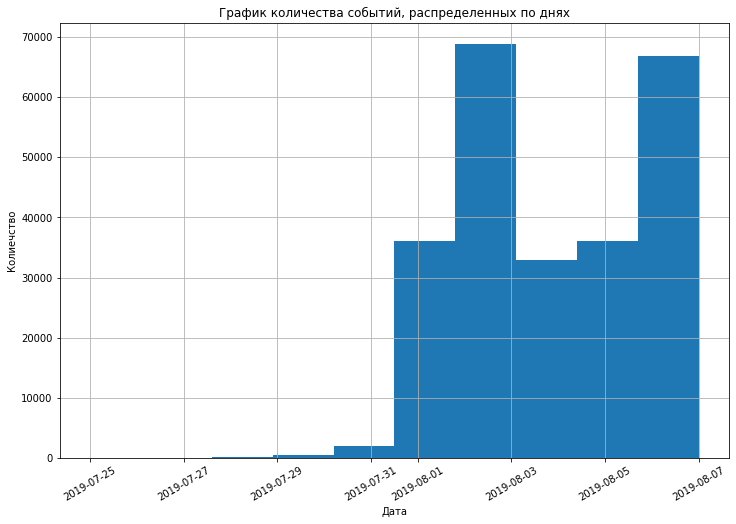

In [16]:
fig = plt.figure(figsize=(12, 8))
data['date'].hist()
plt.title('График количества событий, распределенных по днях')
plt.ylabel('Колиечство')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.show()

Наиболее полные данные есть за период с 1.07.2019 по 07.08.2019. Данные за период с 25.07.2019 по 31.07.2019 стоит откинуть. Откинем не полные данные:


In [17]:
new_data = data.loc[data['event_time'] > '2019-08-01']

In [18]:
event_count_new = len(new_data)
event_count_new
#подсчет событий в очищенном логе

240887

In [19]:
user_id_count_new = new_data['user_id'].nunique()
user_id_count_new
#подсчет уникальных пользователей в очищенном логе

7534

In [20]:
#подсчитаем на сколько событий и пользлвателей изменился очищенный датафрем
difference_event = event_count - event_count_new
percent_event = round(difference_event / event_count * 100, 2)
difference_user_id = user_id_count - user_id_count_new
percent_user_id = round(difference_user_id / user_id_count * 100, 2)
print('Количество потерянных событий после очистки лога', difference_event, 'или',percent_event,'%')
print('Количество потерянных уникальных пользователей после очистки лога', difference_user_id, 'или',percent_user_id,'%')


Количество потерянных событий после очистки лога 2826 или 1.16 %
Количество потерянных уникальных пользователей после очистки лога 17 или 0.23 %


In [21]:
new_data.groupby('group').agg({'user_id': 'count'})
#подсчет количества пользователей в каждой группе

,user_id
group,
246,79302
247,77022
248,84563


После очистки датафрейма удалилось 2826 или 1.16 % событий, уникальных пользователей - 17 или 0.23 %. Выше проверили, что в каждой из трех эксперементальных групп есть пользователи.

Изучили предоставленные данные, всего событий в логе - 243713. Уникальных пользователей - 7551. На одного пользователя в среднем приходится 32 события. Минимальная дата в датафрейме - 25 июля 2019 г, максимальная - 7 августа 2019 г. Мы распологаем данными за 13 дней. Данные необходимо было очистить, т.к. более 95% всех событий приходилось на последнюю неделю. После очистки датафрейма удалилось 2826 или 1.16 % событий, уникальных пользователей - 17 или 0.23 %.

## Изучим воронку событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [22]:
new_data.groupby('event').agg({'user_id': 'count'}).reset_index().sort_values(by='user_id', ascending = False)
#какие события встречаются в логе, как часто они встречаются, сортировка по убыванию

,event,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


В логах встречается 5 событий, наиболее часто встречающиеся - MainScreenAppear. Рассчитаем сколько пользователей совершали каждое событие:	

In [23]:
percent_user_id = new_data.groupby('event')['user_id'].nunique().to_frame().sort_values(by='user_id',ascending=False).reset_index()
percent_user_id['percent'] = (percent_user_id['user_id']/7534)*100
round(percent_user_id,2)
#какое количество уникальных пользователей совершают каждое из событий

,event,user_id,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Рассчитали количество пользователей, которые совершают каждое из событий. Всего уникальных пользователей, после очистки данных - 7534 пользователя, их и взяли за - 100%.

Этапы событий можно перевести следующим образом:
- MainScreenAppear - Главный экран
- OffersScreenAppear - Экран предлжения
- CartScreenAppear - Экран корзины
- PaymentScreenSuccessful	- Экран оплаты, со статусом успешно
- Tutorial	 - Руководство, по пользованию приложением.

Предпологаю, что события происходят в следующем порядке:
- Появляется главный экран;
- Предложение о прохождении обучения по работе с приложением;
- Экран с предложениями товаров;
- Экран с корзиной;
- Экран с успешной оплатой заказа.

Этап Tutorial - Руководство, по пользованию приложением, можно исключить из воронки, т.к. предпологаю, что он является не обязательным, а добровольным, и никак не повлияет на пользователя, на его решение о покупки. 

In [24]:
percent_user_id = percent_user_id[:4]
round(percent_user_id,2)
#удалим из воронки обучение(Tutorial)

,event,user_id,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


Как видим, что не все пользователи попадают на главный экран, возможно часть пользователей попадает с рекланмых источников, сразу на другие события.

Рассчитаем какая доля пользователей, переходит от одного шага к другому, сравнивать шаг будем с предыдущем, т.е. OffersScreenAppear будем считать относительно MainScreenAppear, CartScreenAppear относительно OffersScreenAppear, а PaymentScreenSuccessful	относительно CartScreenAppear:

In [25]:
percent_user_id['%_previous'] = round(percent_user_id['user_id']/percent_user_id['user_id'].shift(1)*100,2)
percent_user_id

,event,user_id,percent,%_previous
0,MainScreenAppear,7419,98.473586,NaN
1,OffersScreenAppear,4593,60.963632,61.91
2,CartScreenAppear,3734,49.561986,81.30
3,PaymentScreenSuccessful,3539,46.973719,94.78


In [48]:
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = percent_user_id['event'],
    x = percent_user_id['user_id'],
textposition = "inside",
    textinfo = "value+percent previous",
opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}))
fig.update_layout(title='Доля пользователей, переходящая с одного шага на другой')
fig.show()

Больше всего пользователей теряется на шаге перехода с главной страницы на страницу с предложениями товаров. Из 100% на второй шаг переходит только 62%. Теперь посмотрим какая доля пользователей доходит от первого этапа до последнего, успешной оплаты заказа:

In [27]:
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = percent_user_id['event'],
    x = percent_user_id['user_id'],
textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}
))
fig.update_layout(title='Доля пользователей, дошедшая от Главного экрана, до успешной оплаты заказа')
fig.show()

Доля пользователей, которая доходит с главного экрана до экрана оплаты со статусом успешно - 48%, что в целом очень неплохо.

## Изучим результаты эксперимента

In [28]:
new_data.groupby('group')['user_id'].nunique()
#подсчитаем количество уникальных пользователей в каждой группе

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Критерии успешного A/A теста:
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [29]:
unique_user_id = new_data.loc[:, ['user_id', 'group']].drop_duplicates().drop(columns=['group'])
unique_user_id.user_id.duplicated().sum()
#количество пользователей оказавшиеся одновременно в разных группах.

0

In [30]:
# Код ревьюера
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
new_data.groupby('user_id').agg({'group':'nunique'}).query('group > 1') 



,group
user_id,


In [31]:
#создадим табличку с событиями, с количеством пользователем на каждом этапе
events_users = new_data.pivot_table(index = 'event',
                                   columns = 'group',
                                   values = 'user_id',
                                   aggfunc = 'nunique').sort_values(by = 246, ascending=False)
# объединим группы 246 и 247
events_users['246+247'] = events_users[246] + events_users[247]
events_users

group,246,247,248,246+247
event,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [32]:
#выведем табличкой количество пользователей, в каждой из групп, для удобства дальнейшего использования
#при проведении тестов
users = new_data.pivot_table(columns = 'group', values = 'user_id',
                        aggfunc = 'nunique')
users['246+247'] = users[246] + users[247]
users

group,246,247,248,246+247
user_id,2484,2513,2537,4997


In [33]:
#рассчитаем разность пользователей в группах 246 и 247, в процентах
round(100 -(users[246]/users[247])*100,2)


user_id    1.15
dtype: float64

Количество пользователей в группах теста 246 и 247 отличается в 1,15 %, что можно считать не значительным.

Разница в группах 246 и 247, в пользователей составляет 1,15 %, что близко к критерию успешного А/А теста,  проверить второй критерии нет возможности. Пользователи, которые попали в несколько групп одновременно отсутствуют.

In [34]:
#доля  пользователей, побывавшая на главном экране в группе 246
percent_user_id_246 = (events_users.loc['MainScreenAppear'][246]/users[246])*100
round(percent_user_id_246 ,2)

user_id    98.63
Name: 246, dtype: float64

In [35]:
#доля  пользователей, побывавшая на главном экране в группе 247
percent_user_id_247 = (events_users.loc['MainScreenAppear'][247]/users[247])*100
round(percent_user_id_247 ,2)

user_id    98.53
Name: 247, dtype: float64

Наибольшее количество пользователей побывало на странице - Главного экрана. Число пользователей, совершивших данное действие, в каждой из контрольных групп: в группе 246 - 2450, что составляет - 98, 63% от общего числа пользователей, в данной группе; в группе 247 - 2476 пользователей побывало на главном экране, или 98,53%. Проверим есть ли статистически значимое отличие между ними:

In [36]:
alpha = .05 # критический уровень статистической значимости

successes_1 =  np.array(events_users.loc['MainScreenAppear'][246])
successes_2 = np.array(events_users.loc['MainScreenAppear'][247])
trials_1 = np.array (users[246])
trials_2 = np.array(users[247])

# пропорция успехов в первой группе:
p1 = successes_1/trials_1

# пропорция успехов во второй группе:
p2 = successes_2/trials_2

# пропорция успехов в комбинированном датасете:
p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

# разница пропорций в датасетах
difference = p1 - p2 
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение:',p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение: [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статически значимых отличий в контрольных группах, между доля по главному экрану - нет. Проведем такое же исследование для других событий, у контрольной группы, для этого создадим функцию:

**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 246 и 247 нет;


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 246 и 247

In [37]:
def stat_test(group_1, group_2, event, alpha ):


    successes_1 = events_users.loc[event, group_1]
    successes_2 = events_users.loc[event, group_2]
    trials_1 = users[group_1]
    trials_2 = users[group_2]
# пропорция успехов в первой группе:
    p1 = successes_1/trials_1

# пропорция успехов во второй группе:
    p2 = successes_2/trials_2

# пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

# разница пропорций в датасетах
    difference = p1 - p2 
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('Событие:',  event)
    print(f'p-значение {p_value}')
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

In [38]:
for event in events_users.index:
    stat_test(246, 247, event, 0.05)
    print()

Событие: MainScreenAppear
p-значение [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.93769962]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статически значимых отличий в долях событий в контрольных группах не найдено. Т.е. статистически значимой разницы между группами 246 и 247 не найдено. Проведем сравнение для эксперементальной группы, сравнив с каждой контрольной группой по очереди, и с обоими сразу:

**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 246 и 248 нет;


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 246 и 248

In [39]:
for event in events_users.index:
    stat_test(246, 248, event, 0.05)
    print()

Событие: MainScreenAppear
p-значение [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.8264294]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 247 и 248 нет;


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 247 и 248

In [40]:
for event in events_users.index:
    stat_test(247, 248, event, 0.05)
    print()

Событие: MainScreenAppear
p-значение [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.76532392]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 246+247 и 248 нет;


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 246+247 и 248

In [41]:
for event in events_users.index:
    stat_test('246+247', 248, event, 0.05)
    print()

Событие: MainScreenAppear
p-значение [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.76486247]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



В ходе исследование между эксперементальной группой 248 и контрольными 246 и 247, не обнаружено статистически значимых различий.  

Для исключения роста вероятности групповых ошибок первого рода проведем еще раз тесты, но уже изменив уровень значимости, с поправкой Бонферрони. Т.к. было проведено 20 тесттов, уменьим уровень значимости в 20 раз:

In [42]:
alpha = 0.05/20
alpha

0.0025

**Нулевая гипотеза:** статистически значимых различий в долях пользователей в группах 246 и 247 нет (с поправкой Бонферрони);

**Альтернативная гипотеза:** есть статистические значимые различия в долях пользователей в группах 246 и 247 (с поправкой Бонферрони)

In [43]:
for event in events_users.index:
    stat_test(246, 247, event, 0.0025)
    print()

Событие: MainScreenAppear
p-значение [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.93769962]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 246 и 248 нет (с поправкой Бонферрони);


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 246 и 248 (с поправкой Бонферрони)

In [44]:
for event in events_users.index:
    stat_test(246, 248, event, 0.0025)
    print()

Событие: MainScreenAppear
p-значение [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.8264294]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 247 и 248 нет (с поправкой Бонферрони);


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 247 и 248 с поправкой Бонферрони);

In [45]:
for event in events_users.index:
    stat_test(247, 248, event, 0.05)
    print()

Событие: MainScreenAppear
p-значение [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.76532392]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая гипотеза**: статистически значимых различий в долях пользователей в  группах 246+247 и 248 нет (с поправкой Бонферрони);


**Альтернативная гипотеза**: есть статистические значимые различия в долях пользователей в группах 246+247 и 248 (с поправкой Бонферрони);

In [46]:
for event in events_users.index:
    stat_test('246+247', 248, event, 0.0025)
    print()

Событие: MainScreenAppear
p-значение [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-значение [0.76486247]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При уменьшении уровня значимости, поправкой Бонферрони, так же не получилось отвергнуть нулевую гипотезу. Статистически значимых отличий между группами не обнаружено, изменение шрифта не повлияло на пользователей, ни на одном их событий

## Вывод

В ходе исследования был проведен анализ поведения пользователей в мобильном приложении. Выяснено, что большего всего пользователей теряется при переходе с главной страницы на страницу с предложениями товаров, около 40%. При переходе на дальнейшие шаги в приложении таких потерь нет. До покупки доходит 48% пользователей от общего числа, что в целом неплохо. Но рекомендуется обратить внимание разработчиков, на переход со страницы главного экрана, на предложения о покупки, выяснить из -за чего такое количество пользователей просаживаются на данном этапе, возможно он не совсем удобный для пользователей. Выяснено, что в среднем на каждого пользователя приходится 32 события. 

В каждой из трех групп примерно одинаковое количество пользователей, нет пользователей, которые попали одновременно в несколько групп. В результате проведенных A/A/B тестов не было выявлено статистически значимых различий, ни в контрольных группах, ни в сравнении с эксперементальной. Для исключения роста вероятности групповых ошибок первого рода провели дополнительные тесты, уже изменив уровень значимости, с поправкой Бонферрони. Но и при уменьшии уровня значимости статистически значимых различий выявить не удалось. Можно сделать вывод, что что выбранный дизайнерами шрифт не влияет на пользователей, на их взаимодействие с приложением.